## Download Modular PyTorch Scripts from GitHub

In [ ]:
import os
import requests
from pathlib import Path

base_url = r"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular"

files = [
    "data_setup.py",
    "engine.py",
    "model_builder.py",
    "predictions.py",
    "train.py",
    "utils.py"]

# os.chdir("Z:/ML")

target_dir = Path("going_modular")

if target_dir.exists():
    print(f"Already exists!")
else:
    print(f"Couldn't find, downloading....")
    target_dir.mkdir(exist_ok=True, parents=True)
    for file_name in files:
        file_url = f"{base_url}/{file_name}"
        response = requests.get(file_url)
        response.raise_for_status()

        file_path = target_dir / file_name
        file_path.write_bytes(response.content)

Already exists!


## `download_data()` Function


In [ ]:
import requests
from pathlib import Path
import os
import zipfile

def download_data(source: str,
                  destination: str,
                  remove_file: bool=True):

    data_path = Path("data/") 
    image_path = data_path / destination

    # os.chdir("Z:/ML")

    if image_path.is_dir():
        print(f"{image_path} already exists!")
    else:
        print(f"Couldn't find {image_path}, downloading......")
        image_path.mkdir(parents=True, exist_ok=True)

        target_file = Path(source).name

        with open(data_path / target_file, "wb") as f:
            response = requests.get(source)
            f.write(response.content)
        
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print("Unzipping.....")
            zip_ref.extractall(image_path)
        
        if remove_file():
            os.remove(data_path / target_file)
    
    return image_path


In [32]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi_10_percent")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data\pizza_steak_sushi_10_percent already exists!
data\pizza_steak_sushi_20_percent already exists!


## `create_writer()` Function

In [33]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None):
    
    time = datetime.now().strftime("%Y-%m-%d")

    base_dir = Path("runs") / time / experiment_name / model_name

    if extra:
        log_dir = base_dir / extra
    else:
        log_dir = base_dir
    
    print(f"Created SummaryWriter saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)

## `train()` Function

In [34]:
from going_modular.engine import train_step, test_step
import torch
from typing import Dict, List
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.SummaryWriter) -> Dict[str, List]:

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)
        
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)

            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)
                               
    if writer:
        writer.add_graph(model, torch.randn(16, 3, 224, 224).to(device))
        writer.close()

    return results


## DataLoader Setup & Initialization for EfficientNet Experiments

In [35]:
from torchvision import transforms
import torchvision
from going_modular.data_setup import create_dataloaders

train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

test_dir = data_10_percent_path / "test"

effnetb0_transforms = torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()
effnetb2_transforms = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

BATCH_SIZE = 16

train_dataloader_10_percent_b0, test_dataloader_b0, class_names = create_dataloaders(train_dir=train_dir_10_percent,
                                                                               test_dir=test_dir,
                                                                               batch_size=BATCH_SIZE,
                                                                               transform=effnetb0_transforms,
                                                                               num_workers=0)

train_dataloader_10_percent_b2, test_dataloader_b2, class_names = create_dataloaders(train_dir=train_dir_10_percent,
                                                                               test_dir=test_dir,
                                                                               batch_size=BATCH_SIZE,
                                                                               transform=effnetb2_transforms,
                                                                               num_workers=0)

train_dataloader_20_percent_b0, _, _ = create_dataloaders(train_dir=train_dir_20_percent,
                                                                               test_dir=test_dir,
                                                                               batch_size=BATCH_SIZE,
                                                                               transform=effnetb0_transforms,
                                                                               num_workers=0)

train_dataloader_20_percent_b2, _, _ = create_dataloaders(train_dir=train_dir_20_percent,
                                                                               test_dir=test_dir,
                                                                               batch_size=BATCH_SIZE,
                                                                               transform=effnetb2_transforms,
                                                                               num_workers=0)

## EfficientNet Model Creation Functions

In [36]:
import torchvision
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else "cpu"

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=len(class_names))).to(device)
    
    model.name = "effnetb0"
    
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=len(class_names))).to(device)
    
    model.name = "effnetb2"
    
    return model

## Experiment Configuration

In [ ]:
num_epochs = [5, 10]

models = ["effnetb0", "effnetb2"]

train_dataloaders = {
    "effnetb0":{
        "data_10_percent_b0":train_dataloader_10_percent_b0,
        "data_20_percent_b0":train_dataloader_20_percent_b0},

    "effnetb2":{
        "data_10_percent_b2":train_dataloader_10_percent_b2,
        "data_20_percent_b2":train_dataloader_20_percent_b2}}

## Model Training Loop

In [102]:
experiment_number = 0

for model_name, data_dict in train_dataloaders.items():
    for dataloader_name, train_dataloader in data_dict.items():
        for epochs in num_epochs:
            experiment_number += 1
            print(f"{experiment_number}. | {model_name} | {dataloader_name} | {epochs}_epochs")

1. | effnetb0 | data_10_percent_b0 | 5_epochs
2. | effnetb0 | data_10_percent_b0 | 10_epochs
3. | effnetb0 | data_20_percent_b0 | 5_epochs
4. | effnetb0 | data_20_percent_b0 | 10_epochs
5. | effnetb2 | data_10_percent_b2 | 5_epochs
6. | effnetb2 | data_10_percent_b2 | 10_epochs
7. | effnetb2 | data_20_percent_b2 | 5_epochs
8. | effnetb2 | data_20_percent_b2 | 10_epochs


In [ ]:
from going_modular.utils import save_model
from torch import nn

experiment_number = 0

for model_name, data_dict in train_dataloaders.items():
    for dataloader_name, train_dataloader in data_dict.items():
        for epochs in num_epochs:
            
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            if model_name == "effnetb0":
                model = create_effnetb0()
                test_dataloader = test_dataloader_b0
            else:
                model = create_effnetb2()
                test_dataloader = test_dataloader_b2
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            save_model(model=model,
                       target_dir="models",
                       model_name=f"{model_name}_{dataloader_name}_{epochs}_epochs.pth")
            
            print( "\n" + "-"*50 + "\n")
            


## Launching TensorBoard in Jupyter

In [40]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2360), started 3 days, 15:11:26 ago. (Use '!kill 2360' to kill it.)

## Load a Trained EfficientNetB2 Model

In [57]:
best_model = create_effnetb2()
best_model_path = "models/effnetb2_data_20_percent_b2_10_epochs.pth"
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

## `pred_and_plot` Visualize Model Predictions on Sample Images

In [90]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def pred_and_plot(model: torch.nn.Module,
                  image_path_lists: list,
                  transform: torchvision.transforms,
                  device: torch.device,
                  k: int=6):
    
    fig = plt.figure(figsize=(9, 9))

    sampled_images_paths = random.sample(image_path_lists, k=k)
    cols = 2
    rows = k // cols

    for i in range(6):
        img = Image.open(sampled_images_paths[i])
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis(False)

        model.to(device)

        with torch.inference_mode():
            transformed_img = transform(img).unsqueeze(dim=0)
            pred = model(transformed_img.to(device))

        pred_probs = torch.softmax(pred, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)
        
        image_path_list = sampled_images_paths[i]
        true_label = image_path_list.parent.name

        if class_names[pred_label] == true_label:
            plt.title(f"pred: {class_names[pred_label]} | true: {true_label} | prob: {pred_probs.max():.2f}", color='green')
        else:
          plt.title(f"pred: {class_names[pred_label]} | true: {true_label} | prob: {pred_probs.max():.2f}", color='red')

    plt.tight_layout()
    plt.show()

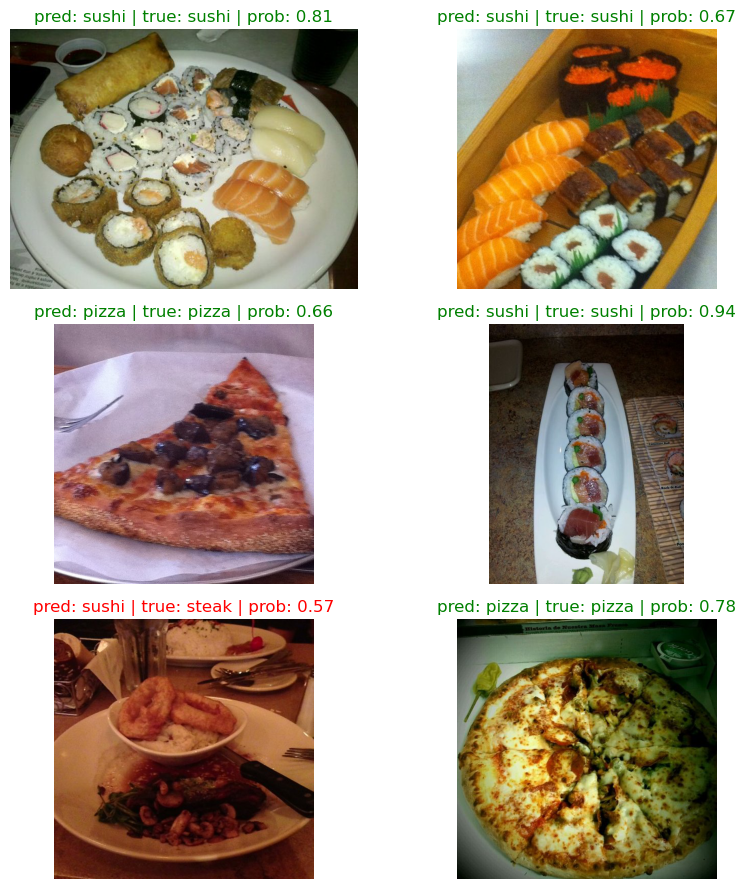

In [93]:
sampled_images_path = list(Path(test_dir).glob("*/*.jpg"))

pred_and_plot(model=best_model,
              image_path_lists=sampled_images_path,
              transform=effnetb2_transforms,
              device=device)

## Generate Predictions and True Labels from Test Set

In [97]:
y_preds = []
labels = []

best_model.eval()
with torch.inference_mode():
    for X, y in test_dataloader_b2:
        X , y = X.to(device), y.to(device)

        y_logits = best_model(X)
        y_pred = torch.argmax(y_logits, dim=1)
        y_preds.append(y_pred)
        labels.append(y)

y_preds_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(labels)

## Plotting a Confusion Matrix for Model Evaluation

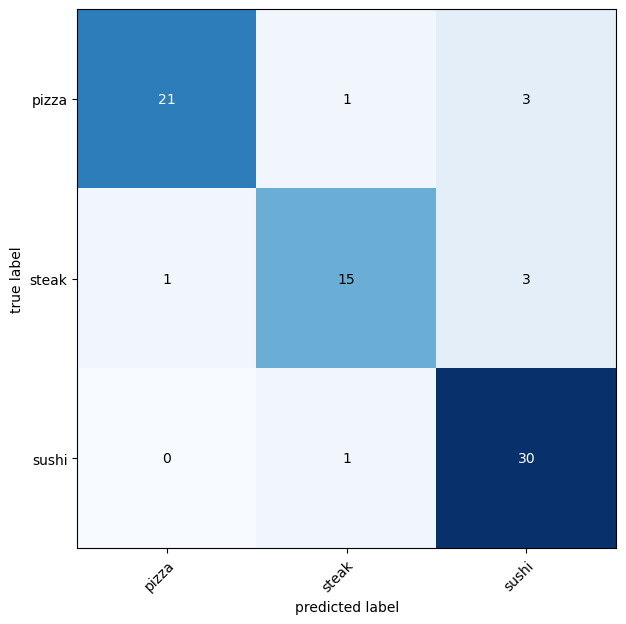

In [101]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))

confmat_tensor = confmat(y_preds_tensor.cpu(), y_true_tensor.cpu())

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))